# **Uma abordagem de PLN para avaliação de eficiência em leitura**

## **Instalação e importação das bibliotecas e componentes**

In [46]:
!pip install --quiet transformers torch scipy numpy pandas spacy nltk
!python -m spacy download pt_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.2/568.2 MB 344.2 kB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [37]:
import ast
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModel
from nltk.metrics import edit_distance

## **Carregamento dos modelos**

In [2]:
nlp = spacy.load("pt_core_news_lg")
model_name = "PORTULAN/albertina-100m-portuguese-ptbr-encoder"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

## **Construção das funções principais**

### **Funções de avaliação e extração de características das palavras**

In [103]:
# Cálculo da similaridade entre duas palavras
def similaridade(palavra1, palavra2):
    encoded_input = tokenizer([palavra1, palavra2],
                              return_tensors='pt', 
                              padding=True, 
                              truncation=True)

    with torch.no_grad():
        model_output = model(**encoded_input)

    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = F.normalize(embeddings, p=2, dim=1)
    cos_sim = torch.mm(embeddings, embeddings.T)[0][1].item()

    return cos_sim


# Extração do lemma e da classe gramatical
def lemma_pos(palavra):
    try:
        doc = nlp(palavra.strip())
        return doc[0].lemma_, doc[0].pos_
    
    except Exception as e:
        print(f"Erro ao processar palavra '{palavra}': {e}")

### **Funções de avaliação de lacuna e cálculo de eficiência em leitura**

In [104]:
PESO_CLASSE = 0.4
PESO_SIMILARIDADE = 0.6

# Avaliação de uma lacuna do teste
def avaliacao_lacuna(gabarito, resposta):
    # Resposta exata
    if resposta == gabarito:
        return 1

    # Resposta em branco
    elif resposta in ["-", "", " ", None]:
        return 0

    # Resposta esperada porém com a grafia errada
    elif edit_distance(resposta, gabarito) <= (len(resposta)//2):
        return 1 - ( edit_distance(resposta, gabarito)/len(resposta))

    # Resposta diferente da esperada
    else:
        lemma_resposta, pos_resposta = lemma_pos(resposta)
        lemma_gabarito, pos_gabarito = lemma_pos(gabarito)

        if pos_resposta == pos_gabarito:
            pontuacao = (1 * PESO_CLASSE) + (similaridade(lemma_resposta, lemma_gabarito) * PESO_SIMILARIDADE)
            return pontuacao

        else:
            return 0

# Cálculo do intervalo de tempo em minutos
def intervalo_tempo(tempo_inicial, tempo_final):
    tempo_inicial = pd.to_datetime(tempo_inicial)
    tempo_final = pd.to_datetime(tempo_final)
    duracao = tempo_final - tempo_inicial
    duracao = duracao.total_seconds() // 60
    
    return duracao

# Avaliação completa do teste
def compreensao_leitura(gabarito, respostas):
    avaliacao_lacunas = [avaliacao_lacuna(gabarito[i], respostas[i]) for i in range(len(respostas))]
    compreensao = np.mean(avaliacao_lacunas)

    return compreensao

In [105]:
# Plotagem da distribuição de respostas
def plot_dist_respostas(df, tipo: {'compreensao', 'percentual_acerto'}):
    plt.figure(figsize=(5, 5))
    sns.histplot(df[tipo], bins=20, kde=True)
    plt.xlim(0, 100)
    plt.title(f"Distribuição da Compreensão de Leitura - {df['ano'].iloc[0]}º {df['turma'].iloc[0]}" if tipo == 'compreensao' else f"Distribuição do Percentual de Acerto - {df['ano'].iloc[0]}º {df['turma'].iloc[0]}")
    plt.xlabel('Compreensão de Leitura (%)' if tipo == 'compreensao' else 'Percentual de Acerto (%)')
    plt.ylabel('Frequência')
    plt.savefig(f"../docs/results/distribuicao_{tipo}_{df['ano'].iloc[0]}-{df['turma'].iloc[0]}.png")
    plt.show()

# Plotagem da eficiência em leitura (Adaptado de Cardoso et al. (2024) - https://osf.io/47m93/.)
def plot_eficiencia_leitura(df, tipo: {'compreensao', 'percentual_acerto'}):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(x=tipo, y='velocidade', data=df,
                    color='black', s=30)

    # Calculando médias
    media_acertos = np.mean(df[tipo])
    media_velocidade = np.mean(df['velocidade'])

    # Adicionando linhas
    plt.axvline(x=media_acertos, color='blue', linestyle='--', linewidth=3)
    plt.axvline(x=44, color='red', linewidth=3)
    plt.axvline(x=58, color='green', linewidth=3)
    plt.axhline(y=media_velocidade, color='blue', linestyle='--', linewidth=3)

    # Configurações do gráfico
    plt.title(f"Desempenho do {df['ano'].iloc[0]}º {df['turma'].iloc[0]}\nCompreensão vs Velocidade" if tipo == 'compreensao' else f"Desempenho do {df['ano'].iloc[0]}º {df['turma'].iloc[0]}\nPercentual de Acerto vs Velocidade", fontsize=14)
    plt.xlabel("Compreensão" if tipo == 'compreensao' else "Percentual de Acerto", fontsize=12)
    plt.ylabel("Velocidade", fontsize=12)
    plt.xlim(0, 100)
    plt.ylim(1, 60)

    plt.tight_layout()
    plt.savefig(f"../docs/results/eficiencia_leitura_{tipo}_{df['ano'].iloc[0]}-{df['turma'].iloc[0]}.png")
    plt.show()

## **Avaliação de Teste Cloze**

### **Gabarito do teste**

In [106]:
import json

# Função para carregar o gabarito do teste
def get_gabarito(titulo):
    with open('../data/textos.json', 'r', encoding='utf-8') as file:
        dados_textos = json.load(file)

    df_textos = pd.DataFrame(dados_textos)

    gabarito = df_textos[df_textos['titulo'] == titulo]['respostas'].values[0]
    return gabarito

### **Dataframe dos testes cloze**

In [107]:
df_cloze = pd.read_csv("../data/raw/dados-ctes_29-02-2024.csv", encoding='utf-8')
df_cloze.head()

,discente,ano,turma,texto,respostas,data,tempo_inicial,tempo_final
0,EST_001,9,B,Consumismo entre os jovens,"['como', 'de', 'atribuido', 'de', 'em', 'do', ...",29-02-2024,08:01,08:09
1,EST_002,7,B,Inseguranças no uso das redes sociais,"['melhora', 'Facilidade', 'todo', 'o', 'desgra...",29-02-2024,07:55,08:28
2,EST_003,7,A,Inseguranças no uso das redes sociais,"['tecnologia', '-', '-', 'o', 'dificuldade', '...",29-02-2024,08:03,08:25
3,EST_004,9,A,Consumismo entre os jovens,"['entre', 'a', 'exercida', 'de', 'aos', 'do', ...",29-02-2024,08:02,08:11
4,EST_005,9,A,Consumismo entre os jovens,"['como', 'de', 'jeito', 'de', 'de', 'de', 'soc...",29-02-2024,08:02,08:10


### **Aplicando a avaliação das lacunas**

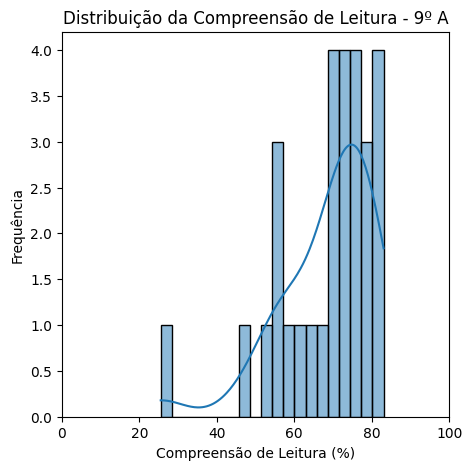

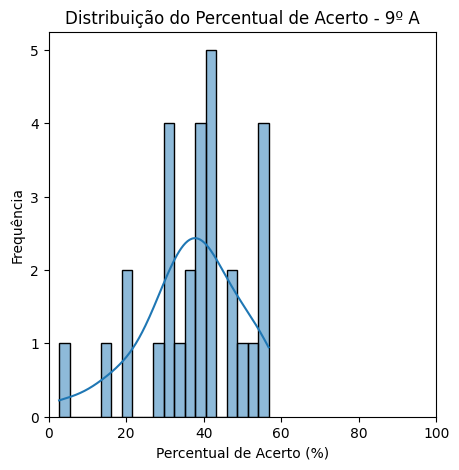

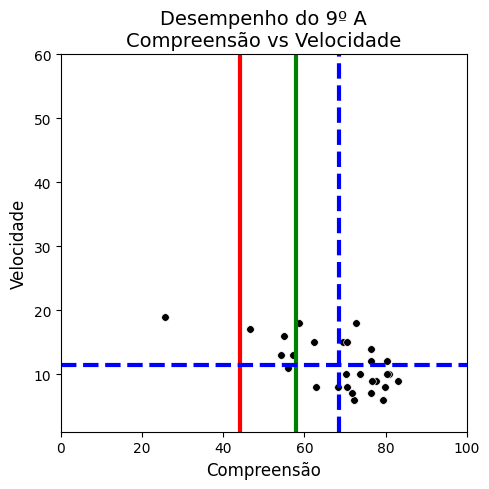

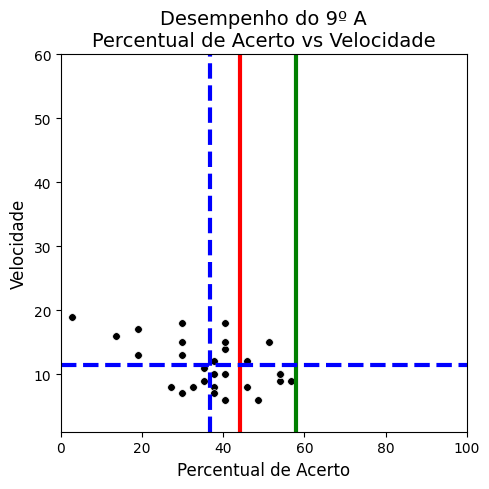

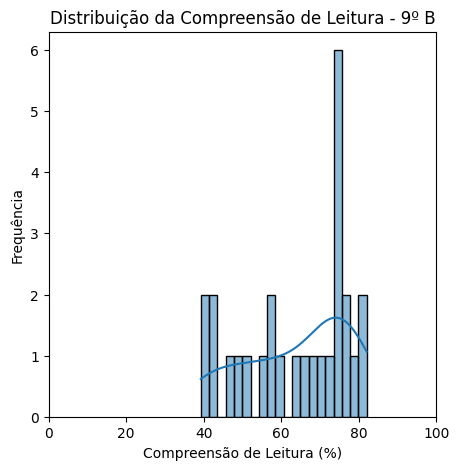

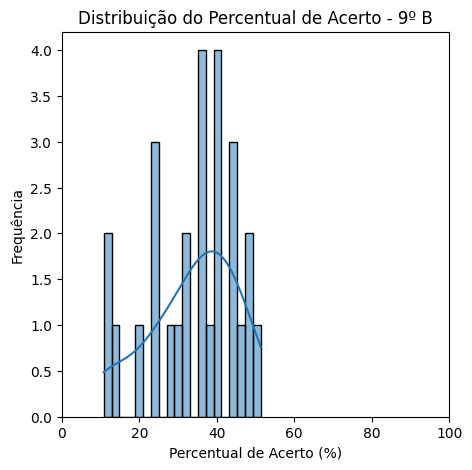

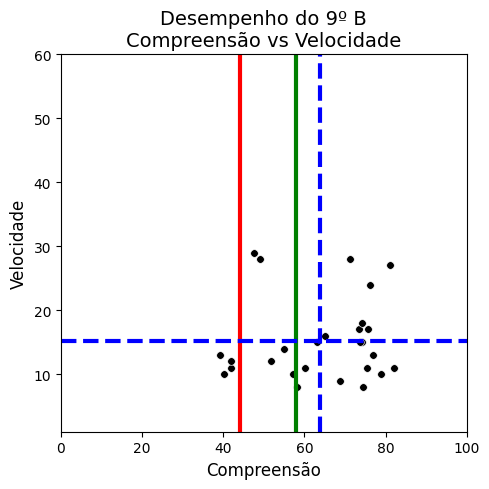

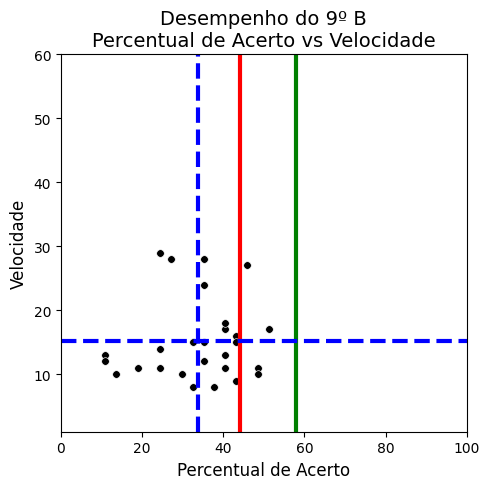

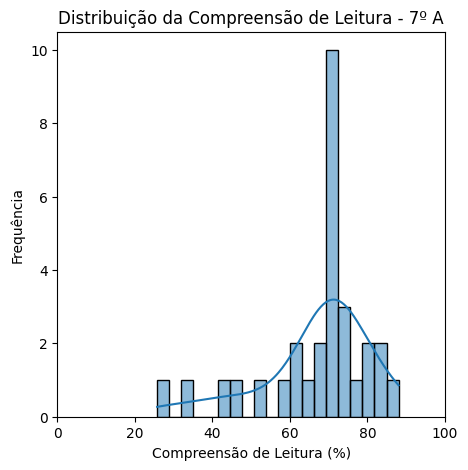

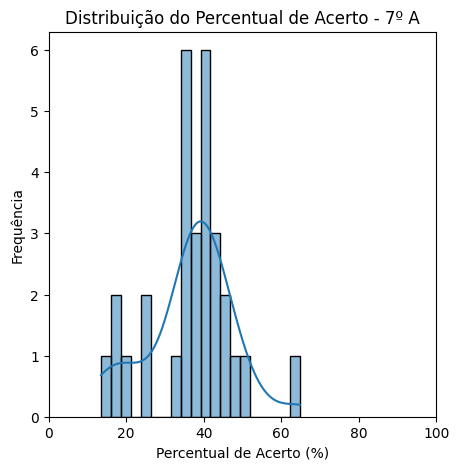

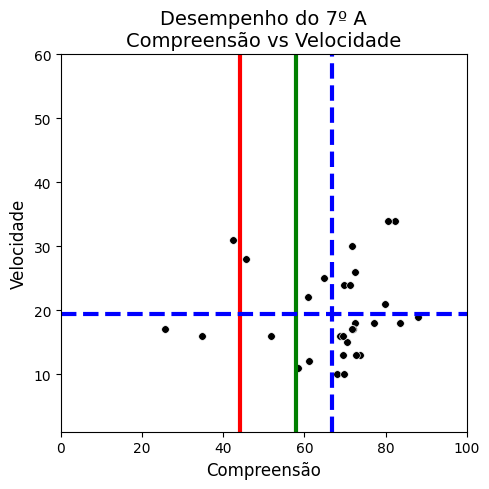

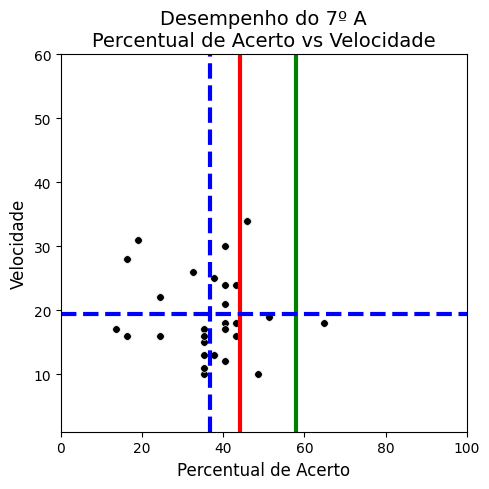

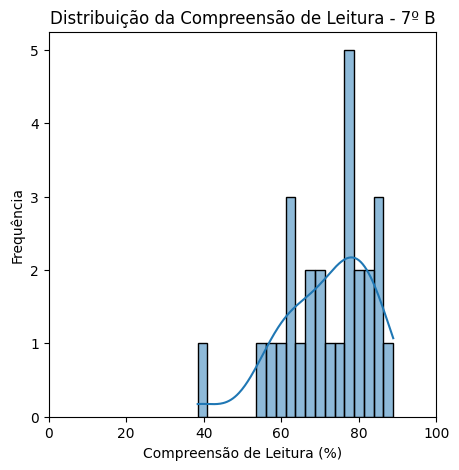

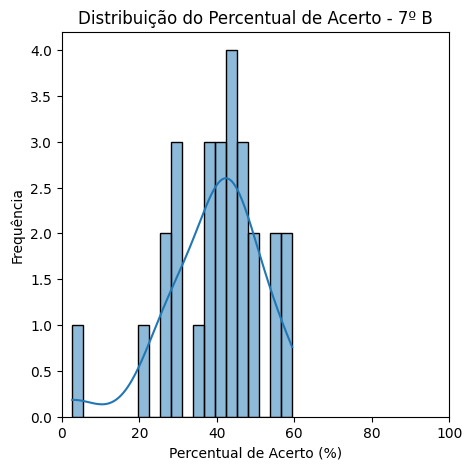

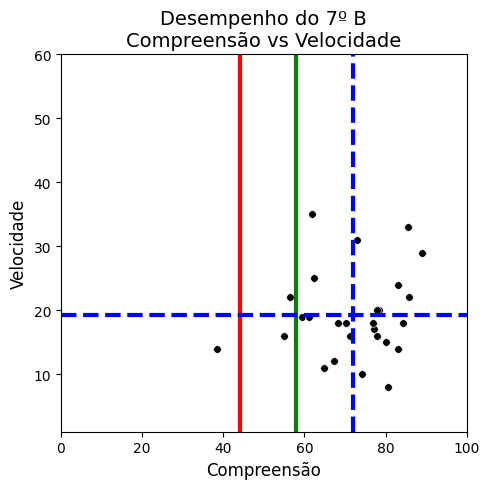

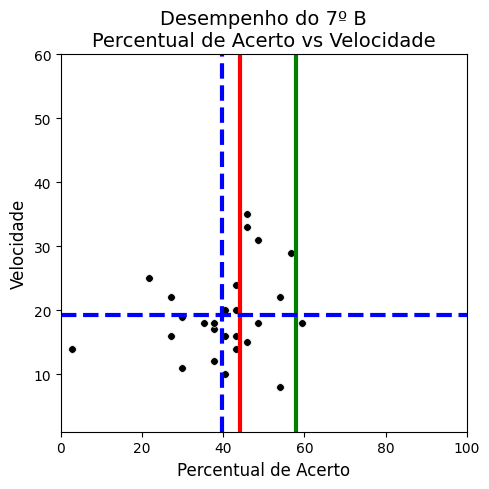

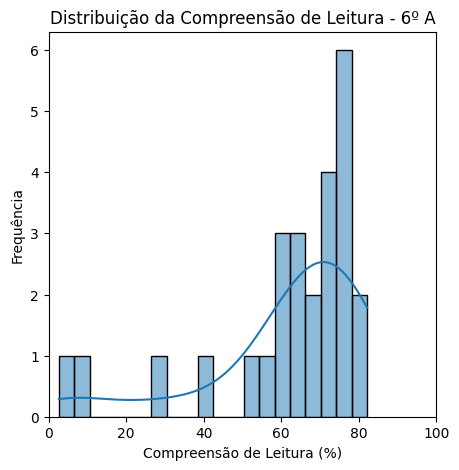

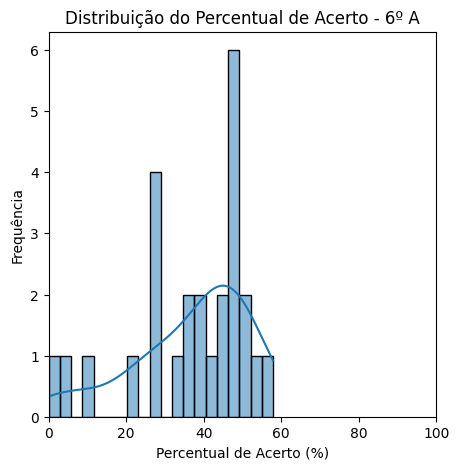

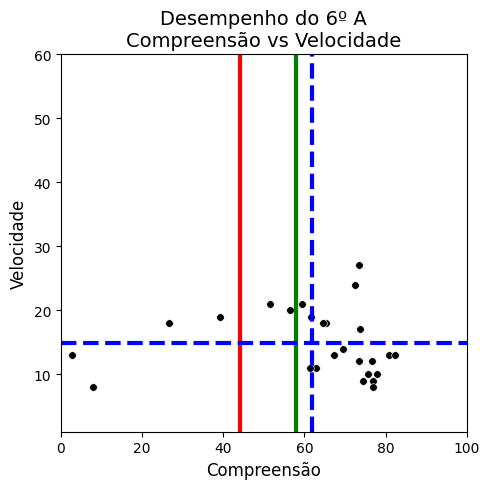

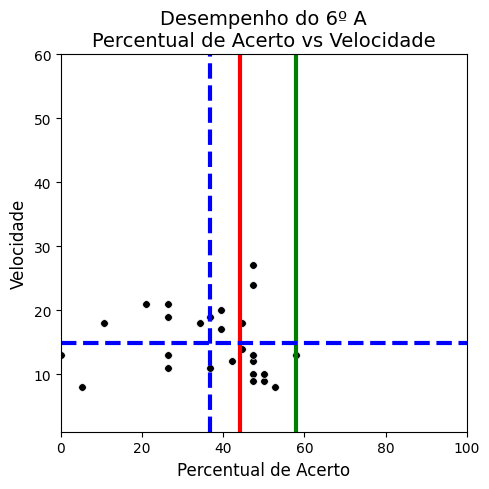

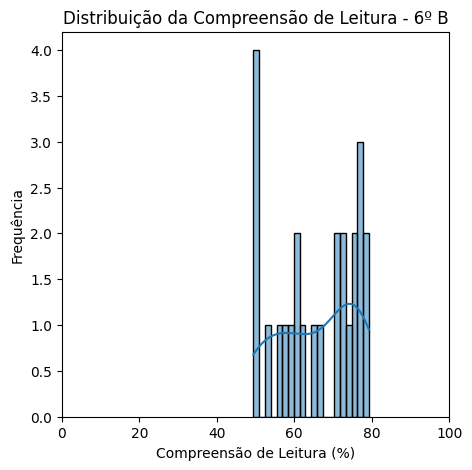

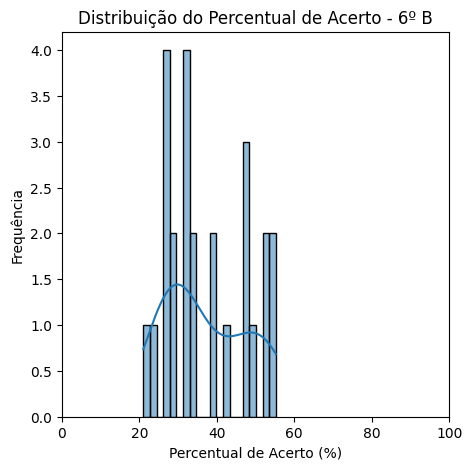

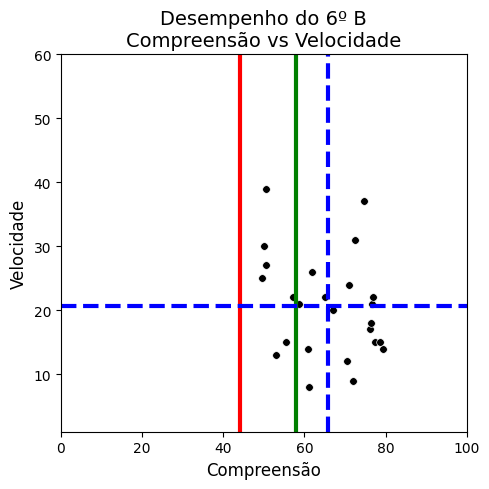

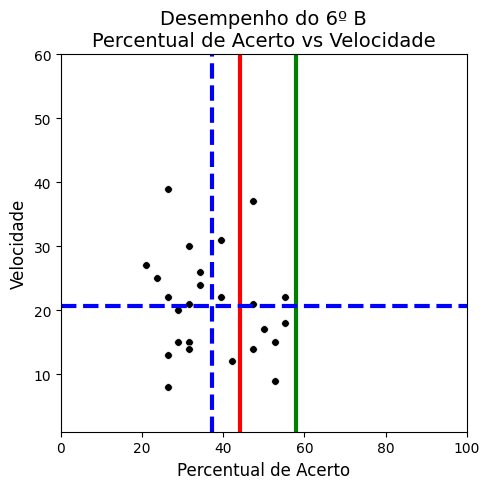

Erro ao processar palavra '': [E040] Attempt to access token at 0, max length 0.


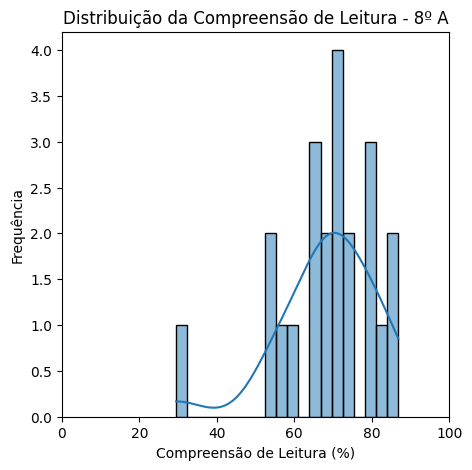

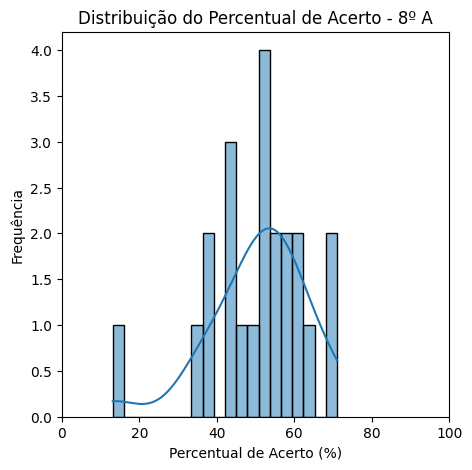

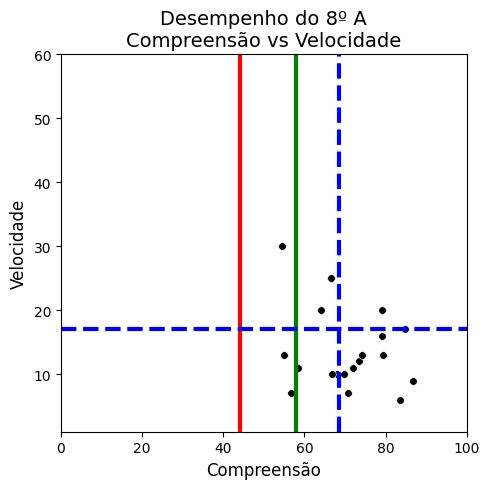

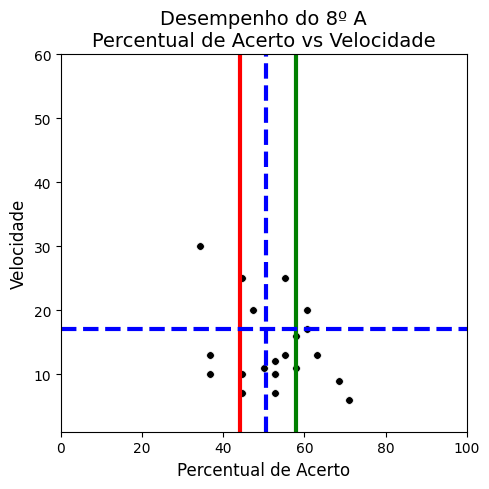

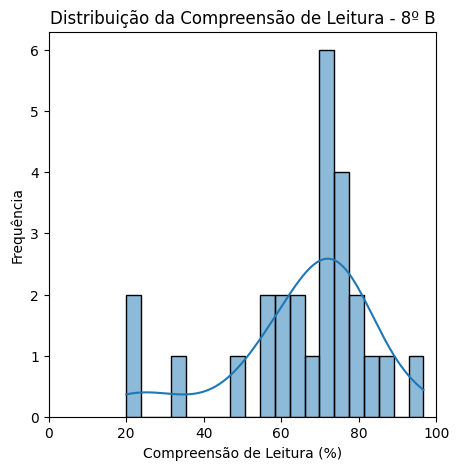

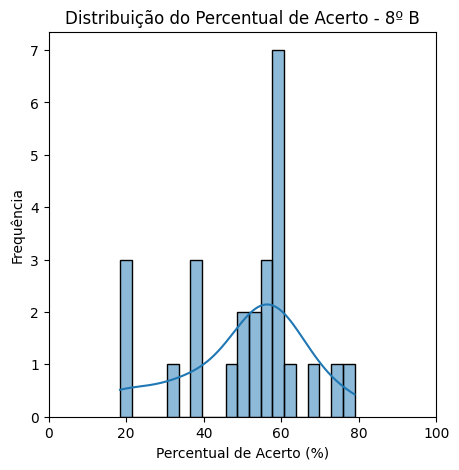

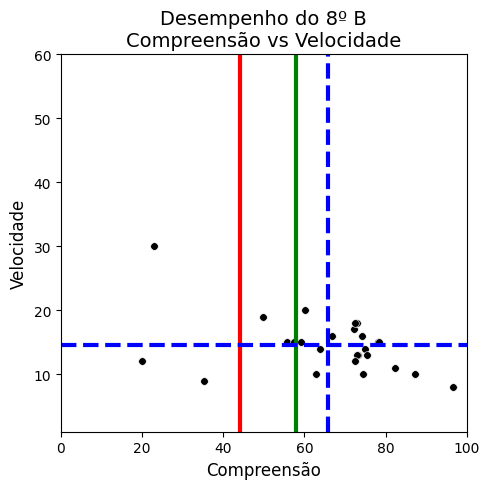

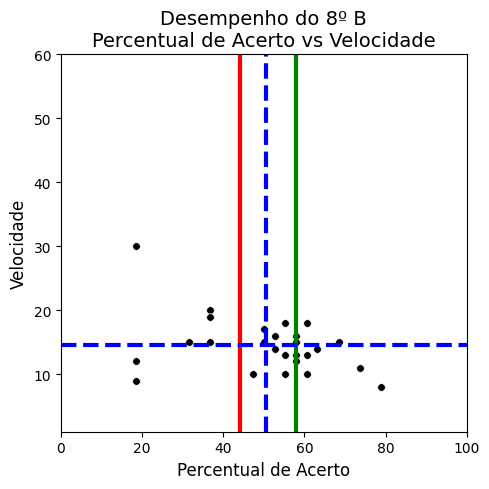

In [111]:
for texto in df_cloze['texto'].unique():
    gabarito = get_gabarito(texto)

    df_temp = df_cloze[df_cloze['texto'] == texto].copy()
    df_temp['respostas'] = df_temp['respostas'].apply(lambda x: ast.literal_eval(x))
    df_temp['lemma_pos'] = df_temp['respostas'].apply(lambda x: [lemma_pos(palavra) for palavra in x])
    df_temp['avaliacao_lacunas'] = df_temp.apply(lambda row: [round(avaliacao_lacuna(gabarito[i], row['respostas'][i]), 3) for i in range(len(row['respostas']))], axis=1)
    df_temp['percentual_acerto'] = df_temp.apply(lambda row: (sum(1 for gabarito, resposta in zip(gabarito, row['respostas']) if resposta.strip().lower() == gabarito.strip().lower()) / len(gabarito) * 100), axis=1)
    df_temp['compreensao'] = df_temp.apply(lambda row: (compreensao_leitura(gabarito, row['respostas']) * 100), axis=1)
    df_temp['velocidade'] = df_temp.apply(lambda row: intervalo_tempo(row['tempo_inicial'], row['tempo_final']), axis=1)
    df_temp = df_temp.reset_index(drop=True)
    df_temp.to_csv(f"../data/processed/avaliacao-cloze_{df_temp['ano'].iloc[0]}-ano.csv", index=False, encoding='utf-8')

    # Visualização dos resultados
    plot_dist_respostas(df_temp[df_temp['turma'] == 'A'], tipo='compreensao')
    plot_dist_respostas(df_temp[df_temp['turma'] == 'A'], tipo='percentual_acerto')    
    plot_eficiencia_leitura(df_temp[df_temp['turma'] == 'A'], tipo='compreensao')
    plot_eficiencia_leitura(df_temp[df_temp['turma'] == 'A'], tipo='percentual_acerto')
    
    plot_dist_respostas(df_temp[df_temp['turma'] == 'B'], tipo='compreensao')
    plot_dist_respostas(df_temp[df_temp['turma'] == 'B'], tipo='percentual_acerto')
    plot_eficiencia_leitura(df_temp[df_temp['turma'] == 'B'], tipo='compreensao')
    plot_eficiencia_leitura(df_temp[df_temp['turma'] == 'B'], tipo='percentual_acerto')
